In [1]:
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import time
import datetime

/Users/dskozlov/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv('features.csv', index_col='match_id')
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [4]:
X = df[df.columns[:102]]
y = df['radiant_win']


# Подход 1: градиентный бустинг "в лоб"

###  1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [5]:
X.count()[X.count() != len(X)]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

In [6]:
# first_blood_time и first_blood_team имеют пропуски, потому что не во всех играх в отведенное время было совершено "Первое убийство" 
# Следовательно время первого убийства и команда, которое это сделала неизвестны => поле не заполнено

In [7]:
X = X.fillna(0)

### 2. Как называется столбец, содержащий целевую переменную?

In [14]:
# Целевая переменная содержится в столбце radiant_win

In [8]:
# Перемешаем выборку
X, y = shuffle(X, y)

In [10]:
n_estimators = [10,15,20,25,30,35,40]
results = []

for n in n_estimators:
    grad_boosting = GradientBoostingClassifier(n_estimators = n, random_state = None)
    
    start_time = datetime.datetime.now()
    result = cross_val_score(estimator = grad_boosting,cv = 5,  X = X, y = y, scoring = 'roc_auc')
    results.append([n,result.mean(),datetime.datetime.now() - start_time])
    results_df = pd.DataFrame(results, columns=['n_estimators','roc_auc','Time elapsed'])

results_df

,n_estimators,roc_auc,Time elapsed
0,10,0.664494,00:00:23.014770
1,15,0.676019,00:00:31.906359
2,20,0.681994,00:00:44.322071
3,25,0.686646,00:00:58.001015
4,30,0.689993,00:01:10.440039
5,35,0.692276,00:01:14.903001
6,40,0.694503,00:01:35.865938


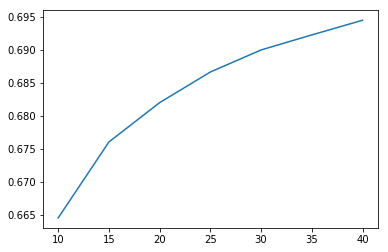

In [12]:
plt.plot(results_df['n_estimators'], results_df['roc_auc'])

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? 

In [ ]:
# Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 00:01:10.440039, качество равно 0.689628

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

In [ ]:
#  Видно, что оптимум не достигнут, имеет смысл использовать больше чем 30 деревьев. Для ускорения обучения можно уменьшить глубину 
#  деревьев или же использовать для обучения не всю выборку. Так же можно уменьшить значение cv = 3. 

# Подход 2: логистическая регрессия

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
C_range = np.logspace(-3, 1, 5)
results = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result = cross_val_score(estimator = log_reg, cv = 5,  X = X_scaled, y = y, scoring = 'roc_auc')
    results.append([c, result.mean(), datetime.datetime.now() - start_time])

    results_df = pd.DataFrame(results, columns=['C','roc_auc','Time elapsed'])

results_df

,C,roc_auc,Time elapsed
0,0.001,0.716106,00:00:08.326361
1,0.010,0.716266,00:00:12.367977
2,0.100,0.716239,00:00:12.221031
3,1.000,0.716235,00:00:11.979003
4,10.000,0.716234,00:00:11.880539


### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [ ]:
# Качество лог. регрессии луше, чем у бистинга. Лучшее значение roc_auc = 0.716266 при C = 0.01. Логисчтическая регрессия работает быстрее
# Качество выше, потому что для лог. регрессия требуется предобработки данных.

In [16]:
X_no_categorial = X.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1)

In [17]:
X_no_catehorial_scaled = scaler.fit_transform(X_no_categorial)

In [19]:
C_range = np.logspace(-3, 1, 5)
results = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result = cross_val_score(estimator = log_reg, cv = 5,  X = X_no_catehorial_scaled, y = y, scoring = 'roc_auc')
    results.append([c, result.mean(), datetime.datetime.now() - start_time])

    results_df = pd.DataFrame(results, columns=['C','roc_auc','Time elapsed'])

results_df

,C,roc_auc,Time elapsed
0,0.001,0.716107,00:00:08.602498
1,0.010,0.716270,00:00:10.843582
2,0.100,0.716242,00:00:12.003101
3,1.000,0.716238,00:00:11.633758
4,10.000,0.716238,00:00:10.919981


### 2.  Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

In [ ]:
# Качество классификации немного увеличилось до 0.716270. Это связано с тем, что были удалены категориальные признаки, 
# которые нельзя сравнивать между собой

### 3. Сколько различных идентификаторов героев существует в данной игре?

In [37]:
columns = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

In [38]:
heroes = []
for i in columns:
    a = X[i].unique().tolist()
    heroes.extend(a)

In [39]:
len(set(heroes))

108

In [ ]:
# Количество используемых геров равно 108, всего 112 героев 

In [40]:
data = X

In [41]:
X_pick = np.zeros((data.shape[0], len(set(heroes))))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-5] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-5] = -1

In [42]:
X_concat = np.concatenate([X_no_catehorial_scaled, X_pick], axis=1)

In [43]:
C_range = np.logspace(-3, 1, 5)
results = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result = cross_val_score(estimator = log_reg, cv = 5,  X = X_concat, y = y, scoring = 'roc_auc')
    results.append([c, result.mean(), datetime.datetime.now() - start_time])

    results_df = pd.DataFrame(results, columns=['C','roc_auc','Time elapsed'])

results_df

,C,roc_auc,Time elapsed
0,0.001,0.744410,00:00:09.509297
1,0.010,0.749418,00:00:15.169096
2,0.100,0.749643,00:00:26.266722
3,1.000,0.749626,00:00:28.138316
4,10.000,0.749623,00:00:27.736065


### 4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

In [44]:
# Наилучшее качество 0.749643 при С = 0.1

In [53]:
df_test = pd.read_csv('features_test.csv', index_col='match_id')
df_test[columns].head()



,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
match_id,,,,,,,,,,
6,93,102,52,53,57,26,89,20,29,39
7,20,6,65,92,43,54,34,93,99,5
10,112,26,29,11,41,91,22,10,49,54
13,27,91,74,52,2,110,25,77,62,49
16,39,93,30,85,102,14,64,70,3,96


In [46]:
X_test_no_categorial = df_test.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1)
X_test_no_categorial = X_test_no_categorial.fillna(0)
X_test_no_categorial_scaled = scaler.fit_transform(X_test_no_categorial)

In [52]:
heroes_test = []
for i in columns:
    a = df_test[i].unique().tolist()
    heroes_test.extend(a)

len(set(heroes_test))

108

In [54]:
data = df_test

X_pick = np.zeros((data.shape[0], len(set(heroes))))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-5] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-5] = -1

/Users/dskozlov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


In [56]:
X_test_concat = np.concatenate([X_test_no_categorial_scaled, X_pick], axis=1)

In [58]:
best_clf = LogisticRegression(penalty='l2', C = 0.1)
best_clf.fit(X_concat, y)
prediction = best_clf.predict_proba(X_test_concat)

### 5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?


In [80]:
max_pred = prediction.max()
min_pred = prediction.min()

print ('Max prediction: ', max_pred)
print ('Min prediction: ', min_pred)

Max prediction:  0.997531532965
Min prediction:  0.00246846703482
